In [21]:
import sys

# laptop
sys.path.append( '/home/greg/current/NMEG_utils/py_modules/' )

# UNM desktop
#sys.path.append( '..\\NMEG_utils\\py_modules\\' )
#af_path = 'C:\\Research_Flux_Towers\\Ameriflux_files\\'
#fig_path = 'figures\\multiyear_figs\\'

import load_nmeg as ld
import transform_nmeg as tr
import plot_nmeg as nmegplt
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

%matplotlib inline
sns.set_style("white")

In [3]:
af_path = '/home/greg/sftp/eddyflux/Ameriflux_files/provisional/'
fig_path = 'figures/multiyear_figs/'

# Years to load
start = 2007
end = 2015
# Sites to load
sites = ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm']

# Since we are calculating some time of day stats we need hourly data
# Fill a dict with multiyear hourly dataframes for each site in sites
hourly = { x : 
          ld.get_multiyr_aflx( 'US-' + x, af_path, gapfilled=True, startyear=start, endyear=end) 
          for x in sites }

# Also open local daily files (we will add to them)
daily_path = '/home/greg/current/NMEG_utils/processed_data/daily_aflx/'
daily = { x : 
         ld.load_local_file( daily_path + 'US-' + x + '_daily_aflx.csv')
         for x in sites }


Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2007_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2008_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2009_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2010_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2011_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2012_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2013_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2014_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2015_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Ses_2007_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Ses_2008_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_

## Make some hourly calculations (C uptake, evaporative fraction)

In [5]:
for site in sites:
    # Add a column with 0.5 for each uptake period (to sum)
    hourly[site]['hrs_C_uptake'] = 0
    test = hourly[site].FC_F < 0
    hourly[site].loc[test, 'hrs_C_uptake'] = 0.5
    
    hourly[site]['evap_frac'] = np.nan
    bowen =  hourly[site].H_F / hourly[site].LE_F
    hourly[site].evap_frac = 1/(1+bowen)
    day_test = hourly[site].SW_IN_F < 50
    hourly[site].loc[day_test, 'evap_frac'] = np.nan
    
# Beware here that the bowen ratio looks a little crazy, especially at night.
# Perhaps we need to do a better job of removing/correcting H and LE fluxes

### Append hourly calculations to daily data

In [5]:

# Get time of min NEE, max GPP, and daily ET and PET
for i, site in enumerate(sites):
    h = hourly[site]
    # Get the time of day for peak GPP each day
    gpp_grp = h.GPP.groupby(h.index.date)
    peakGPP_t = gpp_grp.apply(lambda x: x.index[x==x.max()].time)
    # Get the time of day for peak NEE each day
    nee_grp = h.FC_F.groupby(h.index.date)
    peakNEE_t = nee_grp.apply(lambda x: x.index[x==x.min()].time)
    # Get the time of day for peak RECO each day
    reco_grp = h.RECO.groupby(h.index.date)
    peakRECO_t = reco_grp.apply(lambda x: x.index[x==x.min()].time)
    def get_frac( arr ):
        # Sometimes these are empty
        if len(arr)==0:
            return np.nan
        else:
            return (arr[0].hour*3600 + arr[0].minute*60)/(3600*24)
    #pdb.set_trace()
    daily[site]['hrs_C_uptake_sum'] = h.hrs_C_uptake.resample('1D').sum()
    daily[site]['evap_frac_avg'] = h.evap_frac.resample('1D').mean()
    daily[site][ 'peakGPP_dayfrac'] = peakGPP_t.apply( get_frac )
    daily[site][ 'peakNEE_dayfrac'] = peakNEE_t.apply( get_frac )
    daily[site][ 'peakRECO_dayfrac'] = peakRECO_t.apply( get_frac )
    
# Convert this to a pandas panel
d = pd.Panel(daily)

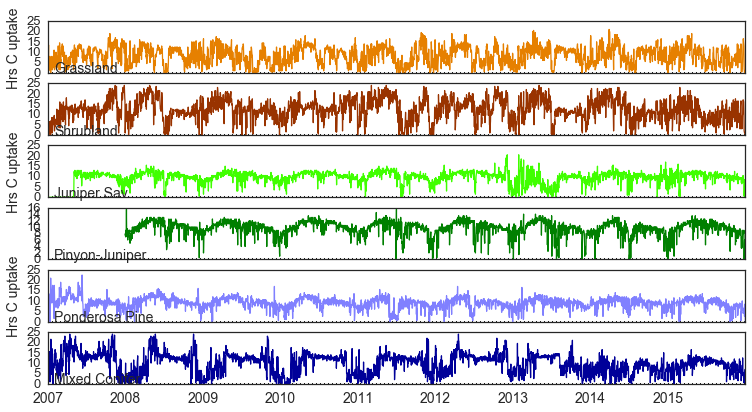

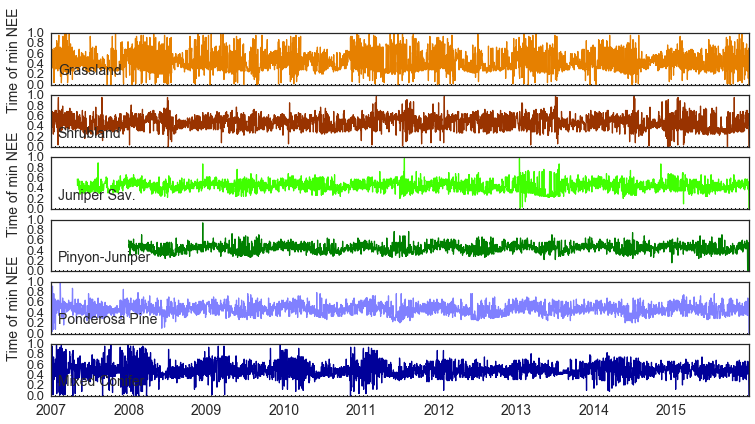

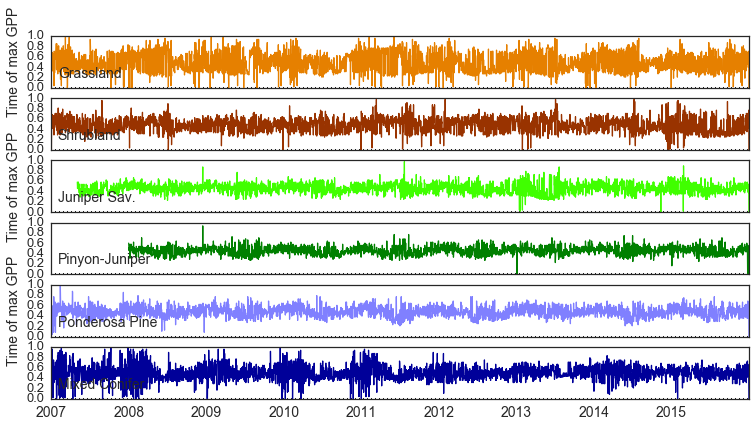

In [9]:
# Plot the hourly calculations to see how they look
fig = plt.figure(figsize=( 12.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
ax = nmegplt.plot_tseries( d, 'hrs_C_uptake_sum', .2, fig, 'Hrs C uptake')
fig = plt.figure(figsize=( 12.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
ax = nmegplt.plot_tseries( d, 'peakNEE_dayfrac', .2, fig, 'Time of min NEE')
fig = plt.figure(figsize=( 12.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
ax = nmegplt.plot_tseries( d, 'peakGPP_dayfrac', .2, fig, 'Time of max GPP')

## Diurnal curves

In [22]:
import math
def get_diurnal_pattern( df, dates, get_inverse=False ):
    # Match days meeting condition to hourly timestamps
    match = pd.to_datetime(df.index.date).isin(dates)
    # Separate the condition from not-condition
    subset = df.loc[match,:]
    # Group by time of day
    mean_30min = subset.groupby(subset.index.time).mean()
    std_30min = subset.groupby(subset.index.time).std()
    std_30min['size'] = subset.groupby(subset.index.time).size()
    
    if get_inverse:
        subset_not = df.loc[~match,:]
        mean_30min_not = subset_not.groupby(subset_not.index.time).mean()
        std_30min_not = subset.groupby(subset.index.time).std()
        std_30min_not['size'] = subset.groupby(subset.index.time).size()
        return mean_30min, mean_30min_not, std_30min, std_30min_not
    else:
        return mean_30min, std_30min

In [23]:
fig = plt.figure(figsize=( 9.5, 12.5 ), dpi=150, facecolor='w', edgecolor='k')
def plot_diurnal( variable ):
    for i, site in enumerate( sites ):
        dates = vpd_anom_cond[site].index[vpd_anom_cond[site]]
        mean_dat, mean_dat_not, std_30min, std_30min_not = get_diurnal_pattern( 
            hourly[ site ], dates, get_inverse=True )
        ax = plt.subplot( 3, 2, i+1 )
        plt.plot(mean_dat.index, mean_dat[variable])
        plt.plot(mean_dat_not.index, mean_dat_not[variable])
        #plt.plot(mean_dat.index, mean_dat[variable] + 
        #         (std_30min[variable] / math.sqrt(std_30min.size)), color='gray', alpha=.5)
        #plt.plot(mean_dat.index, mean_dat[variable] - 
        #         (std_30min[variable] / math.sqrt(std_30min.size)), color='gray', alpha=.5)
        plt.plot(mean_dat.index, mean_dat[variable] + 
                 std_30min[variable], color='blue', alpha=.2)
        plt.plot(mean_dat.index, mean_dat[variable] - 
                 std_30min[variable], color='blue', alpha=.2)
        plt.plot(mean_dat_not.index, mean_dat_not[variable] + 
                 std_30min_not[variable], color='green', alpha=.2)
        plt.plot(mean_dat_not.index, mean_dat_not[variable] - 
                 std_30min_not[variable], color='green', alpha=.2)
        if i==0:
            plt.legend(['Anomaly condition', 'Normal'])
        elif i==2:
            plt.ylabel(variable)
        elif i > 3:
            plt.xlabel('hour of day')
        


plot_diurnal('FC_F')
fig.savefig('../figures/labmeeting/fc_diurnal.svg', dpi=150)

NameError: name 'vpd_anom_cond' is not defined

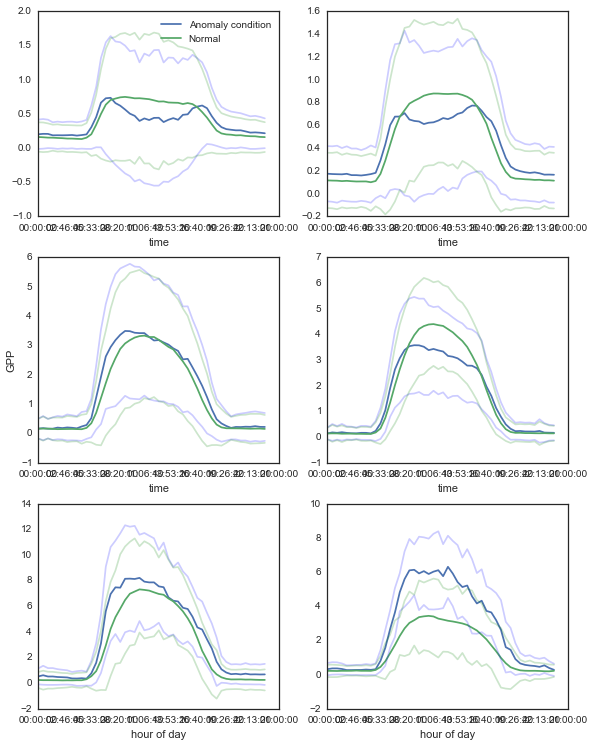

In [19]:
fig = plt.figure(figsize=( 9.5, 12.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_diurnal('GPP')
fig.savefig('../figures/labmeeting/gpp_diurnal.svg', dpi=150)

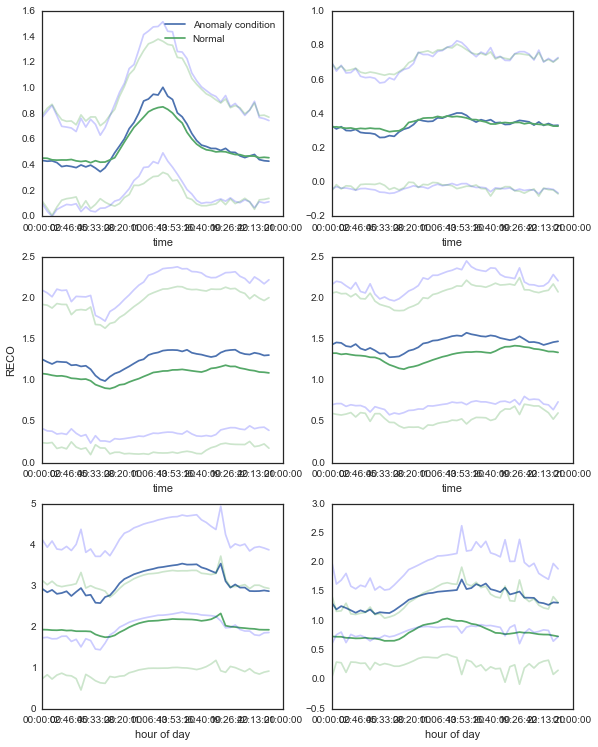

In [20]:
fig = plt.figure(figsize=( 9.5, 12.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_diurnal('RECO')
fig.savefig('../figures/labmeeting/reco_diurnal.svg', dpi=150)